In [1]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
import sys, os
os.chdir('C:\\Users\\Jxpac\\Desktop\\proje\\test\\anaconda')
MODELPATH = 'model\\model.h5'

In [3]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [4]:
data = pd.read_csv('fer2013.csv')

In [5]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


0:anger, 1:disgust, 2:fear, 3:happiness, 4:sadness, 5:surprise, 6:neutral
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


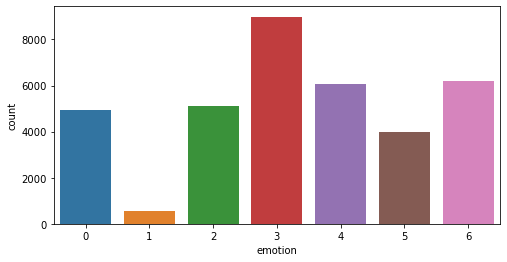

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.countplot(x='emotion',data=data)
print("0:anger, 1:disgust, 2:fear, 3:happiness, 4:sadness, 5:surprise, 6:neutral")
print(data["emotion"].value_counts())
print(data["Usage"].value_counts())


In [7]:
pixels = data['pixels'].tolist() 

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height) 

    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) 

emotions = pd.get_dummies(data['emotion']).to_numpy() 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [9]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

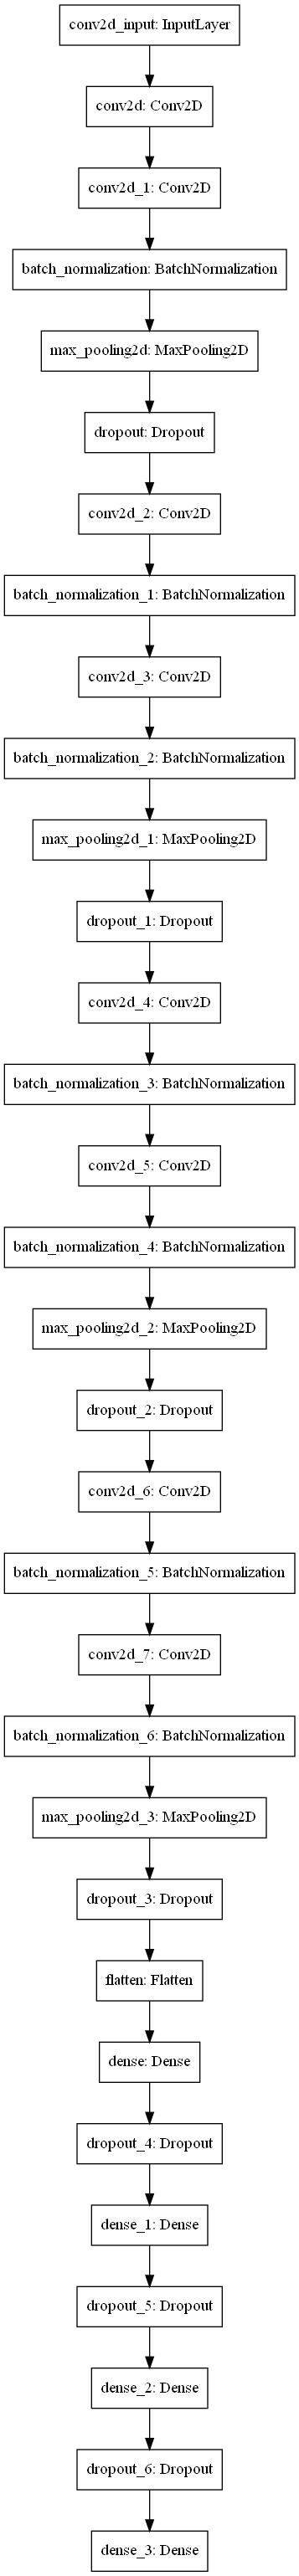

In [11]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [12]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)


In [14]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [15]:
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

In [16]:
history=model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - 58s 114ms/step - loss: 2.2751 - accuracy: 0.2089 - val_loss: 1.8215 - val_accuracy: 0.2458

Epoch 00001: val_loss improved from inf to 1.82153, saving model to model\model.h5
Epoch 2/100
455/455 [==============================] - 50s 109ms/step - loss: 1.8420 - accuracy: 0.2514 - val_loss: 1.8570 - val_accuracy: 0.2455

Epoch 00002: val_loss did not improve from 1.82153
Epoch 3/100
455/455 [==============================] - 48s 107ms/step - loss: 1.7849 - accuracy: 0.2738 - val_loss: 1.7230 - val_accuracy: 0.2940

Epoch 00003: val_loss improved from 1.82153 to 1.72303, saving model to model\model.h5
Epoch 4/100
455/455 [==============================] - 50s 109ms/step - loss: 1.6970 - accuracy: 0.3164 - val_loss: 1.5887 - val_accuracy: 0.3720

Epoch 00004: val_loss improved from 1.72303 to 1.58868, saving model to model\model.h5
Epoch 5/100
455/455 [==============================] - 50s 109ms/step - loss: 1.6108 - accuracy: 0.3596 

In [17]:
from keras import models, layers  
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)

IndexError: list index out of range

In [34]:
max(history.history['val_accuracy'])

0.6511563062667847

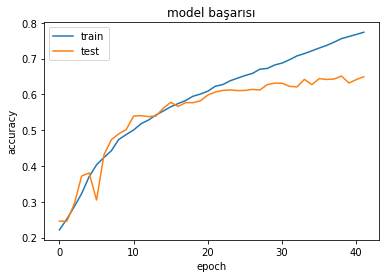

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model başarısı')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

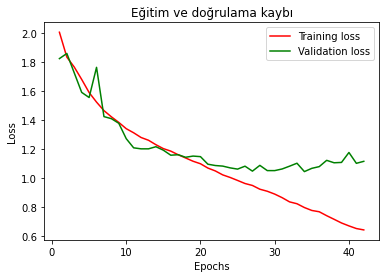

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Eğitim ve doğrulama kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[233   3  44  17  73  10  64]
 [  8  26   0   0   6   1   0]
 [ 49   4 182  21 112  51  44]
 [ 22   0  14 707  22  13  60]
 [ 37   2  40  22 298   7 129]
 [  7   1  16  14   8 294  15]
 [ 32   1  20  42  67   6 386]]


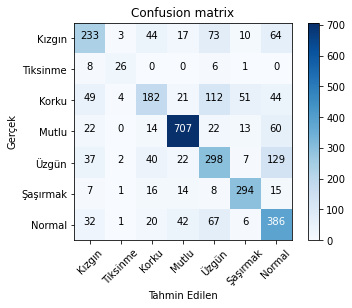

<Figure size 720x576 with 0 Axes>

In [21]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_prediction = model.predict(X_val)
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
labels = ['Kızgın', 'Tiksinme', 'Korku', 'Mutlu', 'Üzgün', 'Şaşırmak', 'Normal']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Gerçek')
plt.xlabel('Tahmin Edilen')
plt.figure(figsize=(10,8))
plt.tight_layout()
plt.show()

6


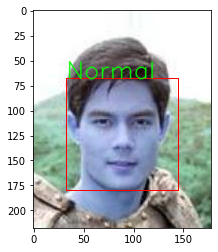

In [22]:
import cv2  
import numpy as np  
from keras.models import load_model

MODELPATH = 'model//model.h5'
emotion_dict = {0: "Kizgin", 1: "Tiksinme", 2: "Korku", 3: "Mutlu", 4: "Uzgun", 5: "Sasirmis", 6: "Normal"}

model = load_model(MODELPATH)
frame = cv2.imread("test\\normal2.jpg") 
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255,0,0,),1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 1, cv2.LINE_AA)  
print(np.argmax(prediction))
plt.imshow(frame)
cv2.destroyAllWindows()

In [23]:
import cv2  
import numpy as np  
from keras.models import load_model

MODELPATH = 'model//model.h5'
emotion_dict = {0: "Kizgin", 1: "Tiksinme", 2: "Korku", 3: "Mutlu", 4: "Uzgun", 5: "Sasirmis", 6: "Normal"}

model = load_model(MODELPATH)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0 , 0), 1, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    if cv2.waitKey(10) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
import cv2 
import numpy as np  
from keras.models import load_model

MODELPATH = 'model//model.h5'
emotion_dict = {0: "Kizgin", 1: "Tiksinme", 2: "Korku", 3: "Mutlu", 4: "Uzgun", 5: "Sasirmis", 6: "Normal"}

model = load_model(MODELPATH)

vid=cv2.VideoCapture('test//test.mp4') 
vid.set(cv2.CAP_PROP_FRAME_WIDTH,480)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT,360) 

import timeit

start = timeit.timeit()

while True:
    ret,frame=vid.read() -
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0 , 0), 1, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    if cv2.waitKey(10) == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()